# Relax, Inc. Takehome Challenge
___

Nils Madsen

11/8/18
___

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# import data
user_data = pd.read_csv('../data/takehome_users.csv', encoding='latin-1')
login_data = pd.read_csv('../data/takehome_user_engagement.csv')

___
### Data Cleaning
___

#### User data

In [3]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
object_id                     12000 non-null int64
creation_time                 12000 non-null object
name                          12000 non-null object
email                         12000 non-null object
creation_source               12000 non-null object
last_session_creation_time    8823 non-null float64
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


In [4]:
# verify all user ids are unique
assert user_data.object_id.nunique() == len(user_data.object_id)

# user names are not useful
user_data.drop('name', axis=1, inplace=True)

# info on last session time would not be available at time of prediction
user_data.drop('last_session_creation_time', axis=1, inplace=True)

# convert account creation time to datetime format
user_data['creation_time'] = pd.to_datetime(user_data.creation_time)

user_data.set_index('object_id', inplace=True)

user_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 7 columns):
creation_time                 12000 non-null datetime64[ns]
email                         12000 non-null object
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null float64
dtypes: datetime64[ns](1), float64(1), int64(3), object(2)
memory usage: 750.0+ KB


#### Login data

In [5]:
login_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
time_stamp    207917 non-null object
user_id       207917 non-null int64
visited       207917 non-null int64
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


In [6]:
# visited has no nan and only one unique value
assert login_data.visited.nunique() == 1
login_data.drop('visited', axis=1, inplace=True)

# verify that all user_ids in login_data are object_ids in user_data
assert all(user_id in user_data.index for user_id in login_data.user_id.unique())

___
### Feature Engineering
___

In [7]:
# extract target variable
login_data['date'] = pd.to_datetime(login_data.time_stamp).dt.date
login_days = login_data.drop_duplicates(subset=['user_id', 'date'])

for user in user_data.index:
    adopted = 0
    adopt_delay = np.nan
    adopt_date = np.nan
    user_logins = login_days[login_days.user_id == user]
    
    for date in user_logins.date:
        period_end = date + pd.Timedelta('7 days')
        
        mask = (user_logins.date >= date) & (user_logins.date < period_end)
        period_logins = user_logins[mask]
        
        if period_logins.date.count() >= 3:
            adopted = 1
            period_logins.sort_values(by='date', inplace=True, ascending=True)
            adopt_date = period_logins.date.iloc[2]
            adopt_delay = adopt_date - user_data.loc[user, 'creation_time'].date()
            break
    
    user_data.loc[user, 'adopted'] = adopted
    user_data.loc[user, 'adopt_date'] = adopt_date
    user_data.loc[user, 'adopt_delay'] = adopt_delay

C:\Users\Nils\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [8]:
# proportion of users retained
user_data.adopted.mean()

0.1335

In [9]:
# extract datetime features from account creation time
user_data['creation_year'] = user_data.creation_time.dt.year
user_data['creation_month'] = user_data.creation_time.dt.month
user_data['creation_day'] = user_data.creation_time.dt.day
user_data['creation_weekday'] = user_data.creation_time.dt.dayofweek
user_data['creation_hour'] = user_data.creation_time.dt.hour
user_data['creation_minuteofday'] = user_data.creation_time.dt.hour*60 + user_data.creation_time.dt.minute
user_data['creation_time_unix'] = user_data.creation_time.astype(np.int64) // 10**9

In [10]:
# extract email provider
user_data['email_provider'] = user_data.email.str.split('@', expand=True)[1]

print(user_data.email_provider.nunique())
user_data.email_provider.value_counts()[0:10]

1184


gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
gustr.com         1179
hotmail.com       1165
xvnbr.com            2
luque.com            2
xybhi.com            2
rerwl.com            2
Name: email_provider, dtype: int64

In [11]:
# label non-major email providers as 'other' to reduce dimensionality
major_providers = set(user_data.email_provider.value_counts()[0:6].index)
mask = ~user_data.email_provider.isin(major_providers)
user_data.loc[mask, 'email_provider'] = 'other'
user_data.email_provider.value_counts()

gmail.com         3562
yahoo.com         2447
jourrapide.com    1259
cuvox.de          1202
other             1186
gustr.com         1179
hotmail.com       1165
Name: email_provider, dtype: int64

In [12]:
# merge inviter information into data
user_data = user_data.merge(user_data[['adopted', 'adopt_date']],
                            how='left',
                            left_on='invited_by_user_id',
                            right_index=True,
                            suffixes=('_user', '_inviter'))

In [13]:
# whether inviter was an adopted user at time of invitation
user_data['inviter_was_adopted'] = np.nan
mask = ~user_data.invited_by_user_id.isnull()
user_data.loc[mask, 'inviter_was_adopted'] = 'False'

mask = (user_data.adopted_inviter == 1) & (user_data.adopt_date_inviter <= user_data.creation_time.dt.date)
user_data.loc[mask, 'inviter_was_adopted'] = 'True'

In [14]:
# remove inviter features
drop_cols = ['adopted_inviter', 'adopt_date_inviter']
user_data.drop(drop_cols, axis=1, inplace=True)

In [15]:
user_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 12000 entries, 1 to 12000
Data columns (total 19 columns):
creation_time                 12000 non-null datetime64[ns]
email                         12000 non-null object
creation_source               12000 non-null object
opted_in_to_mailing_list      12000 non-null int64
enabled_for_marketing_drip    12000 non-null int64
org_id                        12000 non-null int64
invited_by_user_id            6417 non-null object
adopted_user                  12000 non-null float64
adopt_date_user               1602 non-null object
adopt_delay                   1602 non-null object
creation_year                 12000 non-null int64
creation_month                12000 non-null int64
creation_day                  12000 non-null int64
creation_weekday              12000 non-null int64
creation_hour                 12000 non-null int64
creation_minuteofday          12000 non-null int64
creation_time_unix            12000 non-null int64
email_provi

___
### Estimating feature importance with random forest
___

In [16]:
# time span of user account creations is a two-year period
print([user_data.creation_time.min(), user_data.creation_time.max()])

[Timestamp('2012-05-31 00:43:27'), Timestamp('2014-05-30 23:59:19')]


In [17]:
# time span of login data is the same two-year period with an additional week at the end
print([login_data.time_stamp.min(), login_data.time_stamp.max()])

['2012-05-31 08:20:06', '2014-06-06 14:58:50']


In [18]:
# set up datasets for model training
drop_cols = ['adopted_user', 'adopt_date_user', 'adopt_delay', 'email', 'invited_by_user_id', 
             'creation_time', 'creation_year']
X = user_data.drop(drop_cols, axis=1)
y = user_data.adopted_user

X = pd.get_dummies(X, drop_first=False)

# split users by first and second year of dataset timespan
yr1_mask = user_data.creation_time < pd.Timestamp(2013, 5, 31)
yr2_mask = user_data.creation_time >= pd.Timestamp(2013, 5, 31)

X_yr1 = X[yr1_mask]
y_yr1 = y[yr1_mask]

X_yr2 = X[yr2_mask]
y_yr2 = y[yr2_mask]

In [20]:
from sklearn.ensemble import RandomForestClassifier
# cross-validate between year 1 and year 2 users

# fit forest to year 1 users and evaluate on year 2 users
forest_yr1 = RandomForestClassifier(n_estimators=50,
                                    max_depth=len(X.columns),
                                    n_jobs=7,
                                    random_state=234)

forest_yr1.fit(X_yr1, y_yr1)
print(forest_yr1.score(X_yr2, y_yr2))


# fit forest to year 2 users and evaluate on year 1 users
forest_yr2 = RandomForestClassifier(n_estimators=50,
                                    max_depth=len(X.columns),
                                    n_jobs=7,
                                    random_state=345)

forest_yr2.fit(X_yr2, y_yr2)
print(forest_yr2.score(X_yr1, y_yr1))

0.8765185079319708
0.8432940235858485


___
The random forest model does a pretty good job of predicting user adoption, so its determination of relative importance of features in the dataset should be useful.
___

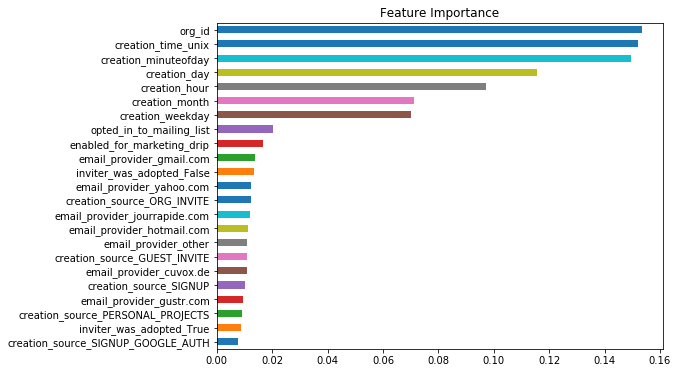

In [40]:
# plot feature importances
feature_importances = forest_yr1.feature_importances_ + forest_yr2.feature_importances_
feature_importances /= 2

feature_importances = pd.Series(feature_importances, index=X.columns)
feature_importances.sort_values(inplace=True)


plt.figure(figsize=(8,6))
feature_importances.plot(kind='barh')
plt.title('Feature Importance')
plt.show()

___
### Exploring the relationship of the features with user adoption
___

Account creation time is the most important feature for predicting user adoption, according to the random forest model. The features derived from account creation time make up 6 of the 7 most important features.

The organization id is the next most important feature, and indicates that certain orgs are more likely to have active users on the service.

The creation source of the account and the user's email provider were the next most important factors.

Other indicators of interest, such as opting in to the mailing list or being on the marketing drip, were the least important factors.

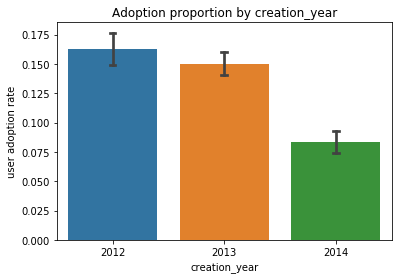

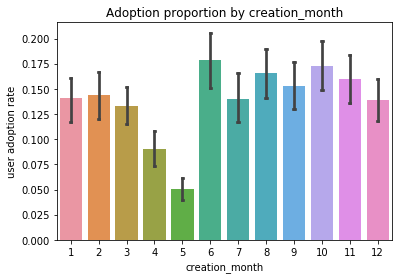

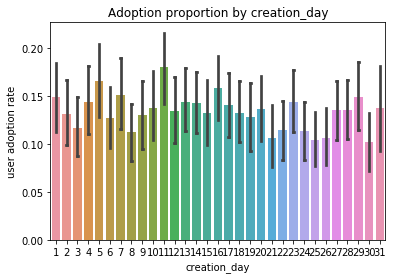

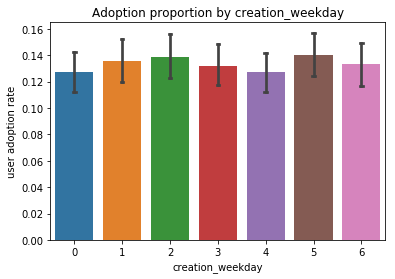

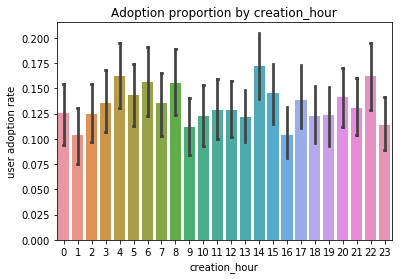

In [22]:
for field in ['creation_year', 'creation_month', 'creation_day', 'creation_weekday', 'creation_hour']:
    # plot user adoption by account creation field
    sns.barplot(x=field, y='adopted_user', data=user_data, capsize=0.05)
    plt.title('Adoption proportion by {}'.format(field))
    plt.ylabel('user adoption rate')
    plt.show()

    print('\n')

___
The most dramatic differences in user adoption appear in the year and month fields.
___

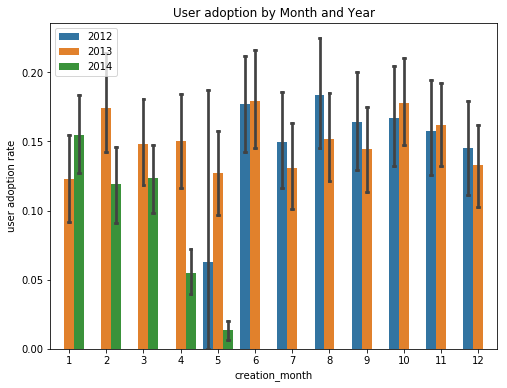

In [41]:
# plot adoption by month and year
plt.figure(figsize=(8,6))
sns.barplot(x='creation_month', y='adopted_user', data=user_data, hue='creation_year', capsize=0.05)
plt.title('User adoption by Month and Year')
plt.ylabel('user adoption rate')
plt.legend(loc='upper left')
plt.savefig('../figures/adopt_by_month_year.png')
plt.show()

___
User adoption rate was relatively steady through 2012 and 2013. However, near the end of the time period of the dataset, in April and May of 2014, there was a strong dropoff in user adoption. This may be an artifact of how user adoption is defined, since users who created an account near the end of the period have had only a few weeks within which to qualify as adopted.
___

In [24]:
print(pd.to_timedelta(user_data[user_data.adopted_user == 1].adopt_delay).median())

48 days 00:00:00


___
The median time it took for an adopted user to qualify as adopted after orginally creating their account was 48 days. This supports the idea that the dropoff in adoption at the end of the data period is an artifact. Users who signed up in the last two months will be removed to address this issue.
___

In [25]:
# retrain random forest with April and May 2014 removed
drop_cols = ['adopted_user', 'adopt_date_user', 'adopt_delay', 'email', 'invited_by_user_id', 
             'creation_time', 'creation_year']
trim_data = user_data[user_data.creation_time < pd.Timestamp(2014, 4, 1)]
X = trim_data.drop(drop_cols, axis=1)
y = trim_data.adopted_user

X = pd.get_dummies(X, drop_first=False)

# split users by first and second year of dataset timespan
yr1_mask = trim_data.creation_time < pd.Timestamp(2013, 5, 31)
yr2_mask = trim_data.creation_time >= pd.Timestamp(2013, 5, 31)

X_yr1 = X[yr1_mask]
y_yr1 = y[yr1_mask]

X_yr2 = X[yr2_mask]
y_yr2 = y[yr2_mask]

In [26]:
# cross-validate between year 1 and year 2 users

# fit forest to year 1 users and evaluate on year 2 users
forest_yr1 = RandomForestClassifier(n_estimators=50,
                                    max_depth=len(X.columns),
                                    n_jobs=7,
                                    random_state=234)

forest_yr1.fit(X_yr1, y_yr1)
print(forest_yr1.score(X_yr2, y_yr2))


# fit forest to year 2 users and evaluate on year 1 users
forest_yr2 = RandomForestClassifier(n_estimators=50,
                                    max_depth=len(X.columns),
                                    n_jobs=7,
                                    random_state=345)

forest_yr2.fit(X_yr2, y_yr2)
print(forest_yr2.score(X_yr1, y_yr1))

0.8487998487998488
0.8376973815710573


___
The model still does a good job at predicting adoption.
___

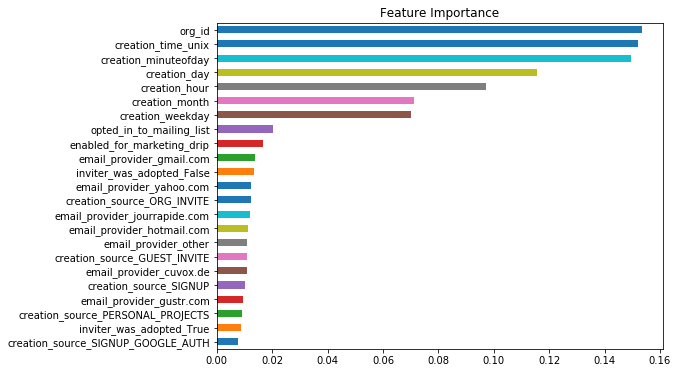

In [42]:
# plot feature importances
feature_importances = forest_yr1.feature_importances_ + forest_yr2.feature_importances_
feature_importances /= 2

feature_importances = pd.Series(feature_importances, index=X.columns)
feature_importances.sort_values(inplace=True)

plt.figure(figsize=(8,6))
feature_importances.plot(kind='barh')
plt.title('Feature Importance')
plt.savefig('../figures/feature_importance.png')
plt.show()

___
The feature importances of the model have barely changed with the removal of the final two months of users. This indicates that the value of account creation time is not largely related to the artifact. 

It is unclear how the model is using the account creation time to inform its predictions. The importance of UNIX time might indicate that the model is recognizing one or more periods over the course of the two years where user adoption was particularly high. The importance of hour and minute of the day might indicate that creating an account during some specific periods of time during the day is informative.
___

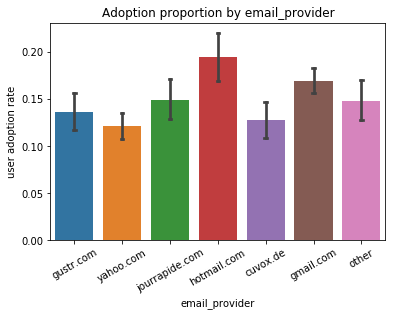

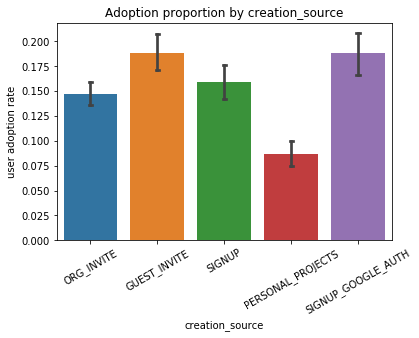

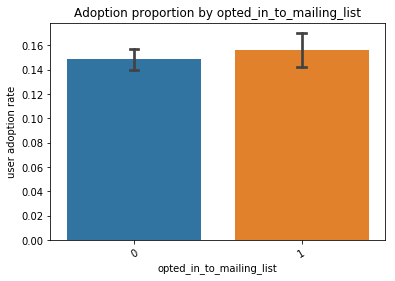

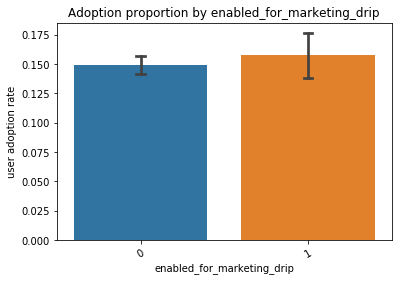

In [43]:
for field in ['email_provider', 'creation_source', 'opted_in_to_mailing_list', 'enabled_for_marketing_drip']:
    # plot user adoption by account creation field
    sns.barplot(x=field, y='adopted_user', data=trim_data, capsize=0.05)
    plt.title('Adoption proportion by {}'.format(field))
    plt.ylabel('user adoption rate')
    plt.xticks(rotation=30)
    plt.savefig('../figures/adopt_by_{}'.format(field))
    plt.show()

    print('\n')

___
The user's email provider appears to have predictive power, with hotmail.com and gmail.com users having highest adoption rates, and yahoo.com and cuvox.de users having the lowest adoption rates.

With regard to the account creation source, guest invites and Google authentication signups showed the highest user adoption rates, while personal project signups showed the lowest adoption rates.

Whether or not the user was signed up to receive emails or was on the marketing drip does not seem to largely impact the chance of adopting the service.
___

___
### Future Directions
___

This is a rich dataset with a lot of potential for feature engineering and investigation into how the features are predictive of user adoption.

One of the most promising avenues for further research is investigating exactly how user account creation time is predictive of user adoption. A moving-average graph of user adoption over the entire 2 year period might show peaks of adoption rate for users creating accounts within specific times of year.

Finally, it would be useful to have data on user logins for at least 2 months after the end of the timespan for user account creations. This would largely fix the artifact seen in the data, where users creating accounts in the final 2 months had a much lower chance of meeting the criteria to be considered adopted.